# Tutorial on ECOSIS API
This jupyter notebook shows how to access [ECOSIS](https://ecosis.org/) API and retrieve data/create visualizations. The API documentation is provided here:http://cstars.github.io/ecosis/.

First, import python modules.

In [1]:
import requests
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Search ECOSIS
We will search for ECOSIS database for the spectra data by their latin names. The latin names of two plant species *Salix nigra* (Black willow) and *Betula papyrifera* (Paper Birch) are provided in the CSV file `plant_latin.csv`. 

In [2]:
# read plant_latin.csv
plant_df =pd.read_csv("plant_latin.csv")
# convert to json string
plant_json = plant_df.to_json(orient='records').replace('","', '"},{"')
plant_json

'[{"Latin Genus":"salix"},{"Latin Species":"nigra"},{"Latin Genus":"betula"},{"Latin Species":"papyrifera"}]'

In [3]:
# base URL of ECOSIS API
baseurl = "https://ecosis.org/api"

# search API url
searchurl = f"{baseurl}/package/search"

# defining search parameters
searchjson = {"filters": plant_json,
             "start":0,
             "stop":100}

# needed to maintain spaces in search parameters
params = urllib.parse.urlencode(searchjson, quote_via=urllib.parse.quote)

# submit request
response = requests.get(searchurl, params=params)
response.raise_for_status()

# print total spectra
print(f"A total of {response.json()['total']} datasets found")

A total of 10 datasets found


Now, let's remove the dataset that have "DO NOT USE" labels in descriptions and get their ids (`_id`).

In [4]:
dataset_id = []
for item in response.json()['items']:
    if ("DO NOT USE" not in item['ecosis']['description']):
        dataset_id.append(item['_id'])

# print      
print(f"A total of {len(dataset_id)} datasets do not have DO NOT USE labels. Their dataset ids are: {dataset_id}")

A total of 9 datasets do not have DO NOT USE labels. Their dataset ids are: ['e384a3ed-9778-49b9-8f84-5c86170b3ea4', 'a12286ac-929f-4e3e-9b9c-517e10fe4087', 'ddca5025-2d9a-4769-b7b8-40153d64559d', '9c835870-a6ac-46b4-b7c0-c9d91b5974b5', 'f72dd538-8350-4d45-ab93-617f3c1da6f0', '5617da17-c925-49fb-b395-45a51291bd2d', '4a63d7ed-4c1e-40a7-8c88-ea0deea10072', 'fea0294d-2d39-4576-aab5-7200fdc87068', '3ac9c116-7507-4916-aa10-b49d0c21c5eb']


## Get dataset
Now, let's retrieve dataset of the first dataset id from the `dataset_id` list above.

In [5]:
# data API url
dataurl = f"{baseurl}/package"

# submit request
response = requests.get(f"{dataurl}/{dataset_id[0]}")
response.raise_for_status()

# total number of spectra
spectra_n = int(response.json()['ecosis']['spectra_count'])

# print
print(f"There are {spectra_n} spectra for dataset id {dataset_id[0]}")

There are 664 spectra for dataset id e384a3ed-9778-49b9-8f84-5c86170b3ea4


## Get Spectra
Now, let's retrieve all 664 spectra of the first dataset id  `e384a3ed-9778-49b9-8f84-5c86170b3ea4`.

In [6]:
# spectra API url
spectraurl = f"{baseurl}/spectra/search"

# initialize pandas dataframe
spectra_df = pd.DataFrame() 

# list of species
spp = plant_df['Latin Genus'] + ' ' + plant_df['Latin Species']
spp_list = spp.str.capitalize().tolist()

# the api only allows 100 items at a time
# this loop is for pagination
for start in range(0, spectra_n+1, 100):
    spectrajson = {"start":start, "stop":start + 99}

    # needed to maintain spaces in search parameters
    params = urllib.parse.urlencode(spectrajson, quote_via=urllib.parse.quote)

    # submit request
    response = requests.get(f"{spectraurl}/{dataset_id[0]}", params=params)
    response.raise_for_status()
    
    for item in response.json()['items']:
        # keep only species that are of interest
        if item['FullSpecies'] in spp_list:
            # getting spectra
            dummy_df = pd.json_normalize(item['datapoints']).apply(pd.to_numeric)
            # species name
            dummy_df['FullSpecies'] = item['FullSpecies']
            # concatenate to pandas dataframe
            spectra_df = pd.concat([spectra_df, dummy_df], ignore_index=True)

# print first few rows
spectra_df = spectra_df.set_index('FullSpecies')
spectra_df[:2]   

,400,401,402,403,404,405,406,407,408,409,...,2391,2392,2393,2394,2395,2396,2397,2398,2399,2400
FullSpecies,,,,,,,,,,,,,,,,,,,,,
Betula papyrifera,0.114593,0.116645,0.114543,0.109993,0.103421,0.094132,0.085405,0.078824,0.074017,0.071295,...,0.373379,0.373272,0.373074,0.372713,0.372258,0.37176,0.371235,0.370832,0.370533,0.370356
Betula papyrifera,0.114576,0.116475,0.114761,0.110390,0.103725,0.094777,0.086170,0.079279,0.074408,0.071272,...,0.362905,0.362928,0.362785,0.362355,0.361798,0.36129,0.360813,0.360531,0.360414,0.360234


## Plot Spectra
Below, we plot spectra of two species in the dataset id `e384a3ed-9778-49b9-8f84-5c86170b3ea4`.

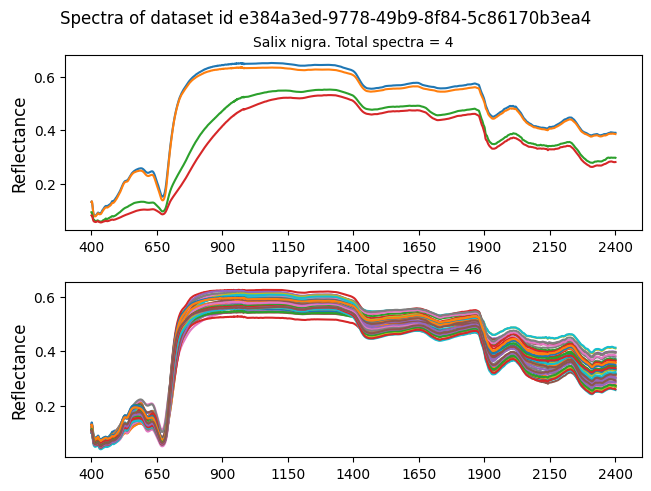

In [7]:
fig, axs = plt.subplots(2, 1, constrained_layout=True)
fig.suptitle(f"Spectra of dataset id {dataset_id[0]}", fontsize=12)

for i, item in enumerate(spp_list):
    # transpose and plot species
    spp_df = spectra_df.loc[item]
    axs[i] = plt.subplot(2,1,i+1)
    spp_df.T.plot(ax=axs[i], legend=None)
    axs[i].set_ylabel('Reflectance', fontsize=12)
    axs[i].set_title(f"{item}. Total spectra = {len(spp_df.index)}", fontsize=10)

plt.show()

## Get Statistics
Statistics endpoint `/stats` of the API gives sum, count, min, max, avg, variance and stddev of the dataset. We will now loop through all 9 datasets and plot the average spectra value as well as its stddev as error bands. Note that these dataset includes spectra from all species (not just *Salix nigra* and *Betula papyrifera*).

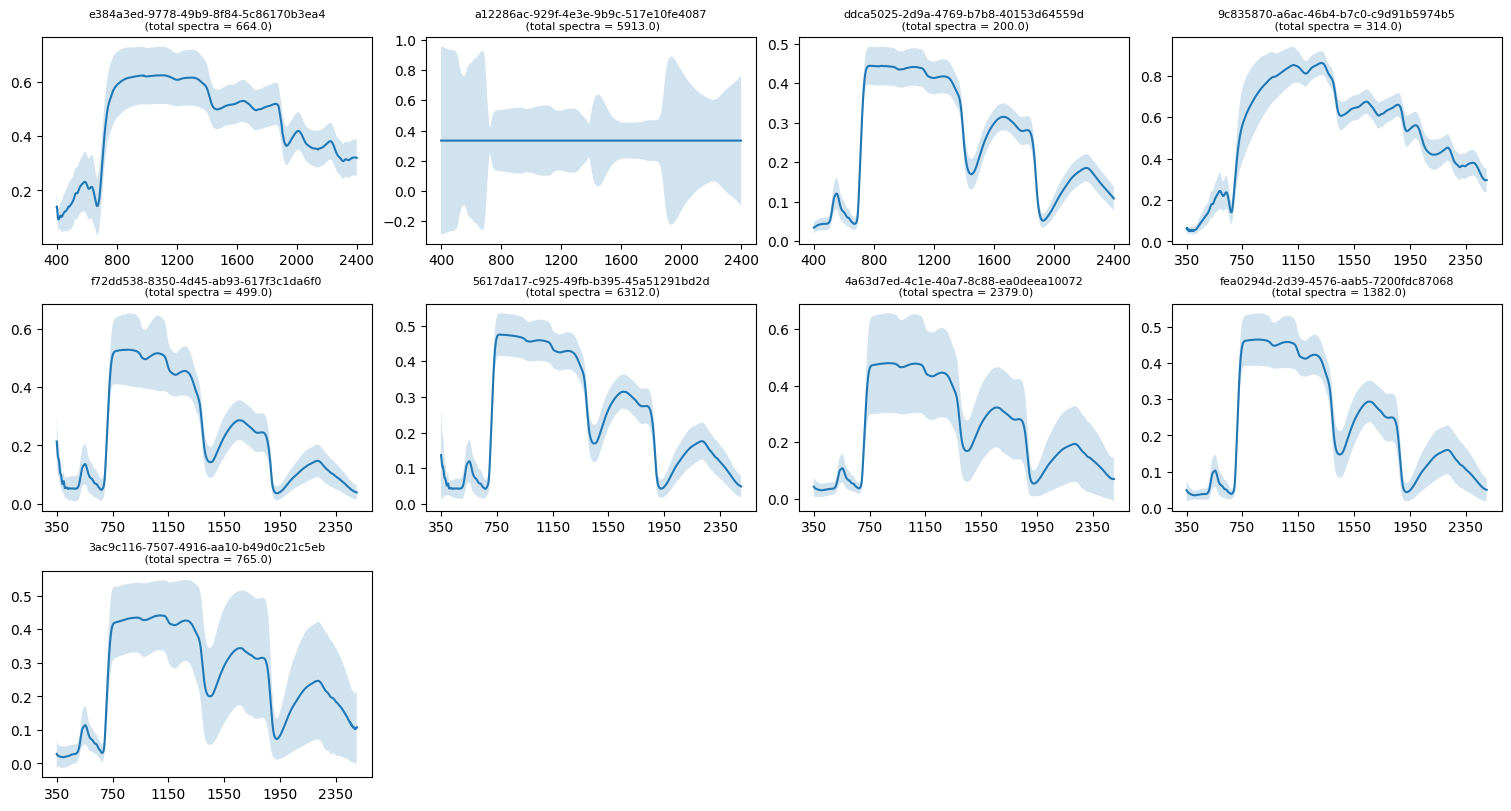

In [8]:
# spectra API url
staturl = f"{baseurl}/spectra/stats"
fig=plt.figure(figsize=(15,8), constrained_layout = True)

columns = 4
rows = int(len(dataset_id)/columns)+1
for i in range(1, len(dataset_id)+ 1):
    # submit request
    response = requests.get(f"{staturl}/{dataset_id[i-1]}")
#     print(f"{dataset_id[i-1]}")
    response.raise_for_status()
    
    # keep the data to json
    df = pd.json_normalize(response.json(), max_level=0).T
    df = pd.concat([df.drop(columns=df.columns[0], axis=1), df[df.columns[0]].apply(pd.Series)], axis=1)
    
    ax = fig.add_subplot(rows, columns, i)
    ax.plot(df.index, df['avg'])
    ax.fill_between(df.index, df['avg']-df['stddev'], df['avg']+df['stddev'], alpha=0.2)
    ax.set_xticks(ax.get_xticks()[::400])
    ax.set_title(f"{dataset_id[i-1]}\n (total spectra = {df['count'].iloc[0]})", fontsize=8)

plt.show()